## Create Shoreline Boundary

Shoreline shapelfile data is sourced from [Geodata.gov.gr](https://geodata.gov.gr/en/dataset/aktogramme/resource/1ba9f74e-eb7a-4d0d-8858-864218806dbc).  This data is filtered for relevant islands and converted to a usable projection before being exported for use in data image sourcing.

***Why use these shapefiles?***

The goal is to source relevant, high resolution, small scale images covering the areas of interest. For the purposes of this project, an island.  Islands are oddly shaped and often do not conform to a grid-like search well.  The shoreline can be used to limit the amount of 'blue space' captured when searching gridwise over the map and capturing images.

In [2]:
import geopandas as gp
import geemap

import shapely
import fiona
from shapely.ops import polygonize

In [3]:
# Read in Coastline Data
# Cite: https://geopandas.org/en/stable/docs/user_guide/io.html
coastlines_shp = gp.read_file('../data/raw_data/aktogrammh/aktogrammh.shp')

In [4]:
type(coastlines_shp)

geopandas.geodataframe.GeoDataFrame

In [5]:
coastlines_shp['TYPE'].value_counts()

AKTH      5234
KRATOS     218
Name: TYPE, dtype: int64

In [6]:
coastlines_shp = coastlines_shp[coastlines_shp['TYPE'] == 'AKTH']

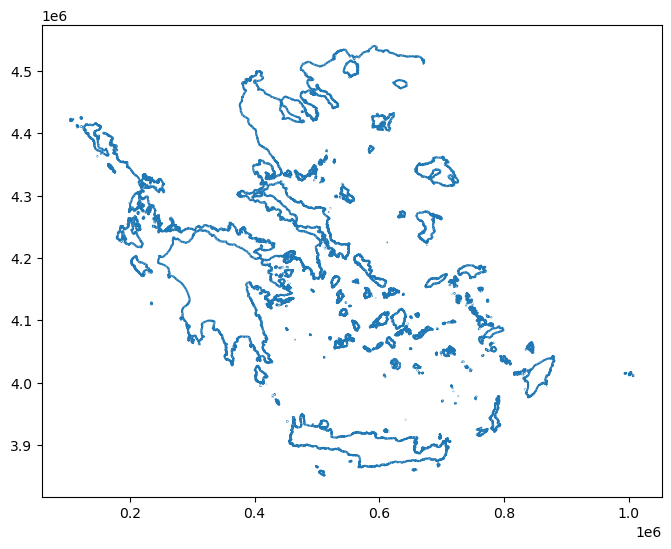

In [7]:
coastlines_shp.plot(figsize = (8,8));
# We are interested first in the island of Corfu (anglicized) shaped like a chili pepper at the top left of the shape file

In [8]:
coastlines_shp[round(coastlines_shp['LENGTH']) == 5274]
#Searching on the mapped version of this shapefile on the site, I found a unique distance around Barbati on Corfu.  We want the shapes connected to this one.
#Unfortunately, these files do not have identifiers for individual islands.  We will need to parse the geopandas objects out by what the continuous points contain.

,LENGTH,TYPE,geometry
2016,5273.587,AKTH,"LINESTRING (143078.750 4402332.999, 143068.500..."


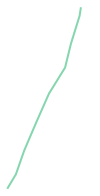

In [9]:
coastlines_shp['geometry'].values[2016]

In [10]:
coastlines_shp.shape

(5234, 3)

### Convert Lines to Polygons

In [13]:
# Cite: usage of polygonize: https://stackoverflow.com/questions/68312843/how-to-create-polygons-from-linestring-unsorted-list
polygons= gp.GeoSeries(polygonize(coastlines_shp['geometry']))

In [14]:
polygons.shape

(2025,)

### Identify Corfu
Corfu is the island of interest for the first iteration of this project.  It is the island which is seventh largest in Greece.
Area approach: cite Katie

In [15]:
polygons.area.sort_values(ascending = False).head(20)

91      2.133053e+10
1944    8.264618e+09
425     3.654527e+09
1791    1.636734e+09
1322    1.407683e+09
1891    8.439247e+08
691     7.805659e+08
643     5.906856e+08
1854    4.787386e+08
1758    4.770332e+08
1538    4.301743e+08
620     4.053277e+08
924     3.837499e+08
1446    3.810352e+08
1033    3.529256e+08
1412    3.009094e+08
724     3.002149e+08
213     2.881025e+08
142     2.772280e+08
1863    2.546762e+08
dtype: float64

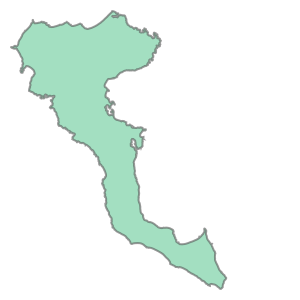

In [16]:
polygons.values[643]

In [17]:
corfu = polygons[643]

In [18]:
type(corfu)

shapely.geometry.polygon.Polygon

### Re-Project Shoreline of Island of Interest
Set up to check wether lat/long points are located inside the boundary of Corfu

In [19]:
# https://geopandas.org/en/stable/docs/user_guide/projections.html#
corfu = gp.GeoSeries(corfu, crs = 'PROJCS["Greek_Grid",GEOGCS["GCS_GGRS_1987",DATUM["D_GGRS_1987",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",24.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')
# crs sourced from [aktogrammh.proj]

In [20]:
type(corfu)

geopandas.geoseries.GeoSeries

In [21]:
corfu.crs

<Projected CRS: EPSG:2100>
Name: GGRS87 / Greek Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Greek Geodetic Reference System 1987
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [22]:
# Re-project the original CRS to a convention which is compatible with long/lat
#cite: https://gis.stackexchange.com/a/412821
corfu = corfu.to_crs(4326)

In [23]:
corfu.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
point = shapely.Point(19.83, 39.596)

In [25]:
type(point)

shapely.geometry.point.Point

In [26]:
shapely.contains(corfu, point)
# Success!

0    True
dtype: bool

In [27]:
# Save Coastline
corfu.to_file('../data/clean_data/coastlines/corfu.shp')

---
## Create District Boundaries

The island of Corfu (Kerkyra) covers 610 sq. kilometers and is home to over 100k people year round.  Helping to narrow down the search for a specific building is key to the success of the project and usefulness to end users.  Ideally, town boundaries would be available.  Here Municipalitity boundaries are publicly available and used.

Municipality Boundaries as defined by the Kapodistrias plan.
Source: [geodata.gov.gr](https://geodata.gov.gr/en/dataset/oria-demon-kapodistriakoi)

In [27]:
munis = gp.read_file('../data/raw_data/oria_kapodistriakwn_dhmwn/oria_kapodistriakwn_dhmwn.shp', encoding = 'cp1253')

In [28]:
munis.head()

,ESYE_ID,GREEKNAME,PREF_ID,PREFECTURE,EDRA,geometry
0,42160000,ΛΙΒΑΔΙΟΥ,42,Ν. ΛΑΡΙΣΑΣ,ΛΙΒΑΔΙ,"POLYGON ((345534.059 4450741.999, 345612.906 4..."
1,42220000,ΟΛΥΜΠΟΥ,42,Ν. ΛΑΡΙΣΑΣ,ΚΑΛΛΙΘΕΑ,"POLYGON ((357296.501 4448098.500, 357326.689 4..."
2,42630000,ΚΑΡΥΑΣ,42,Ν. ΛΑΡΙΣΑΣ,ΚΑΡΥΑ,"POLYGON ((360811.719 4434188.501, 360851.063 4..."
3,61010000,ΚΑΤΕΡΙΝΗΣ,61,Ν. ΠΙΕΡΙΑΣ,ΚΑΤΕΡΙΝΗ,"MULTIPOLYGON (((375994.000 4462421.000, 375876..."
4,61020000,ΑΙΓΙΝΙΟΥ,61,Ν. ΠΙΕΡΙΑΣ,ΑΙΓΙΝΙΟ,"MULTIPOLYGON (((385995.813 4480598.500, 385855..."


In [29]:
munis_c = munis[munis['PREF_ID'].astype(int) == 22]

In [32]:
munis_c.head(2)

,ESYE_ID,GREEKNAME,PREF_ID,PREFECTURE,EDRA,geometry
970,22080000,ΛΕΥΚΙΜΜΑΙΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΛΕΥΚΙΜΜΗ,"POLYGON ((164046.929 4368395.712, 164445.390 4..."
971,22110000,ΠΑΞΩΝ,22,Ν. ΚΕΡΚΥΡΑΣ,ΠΑΞΟΙ,"MULTIPOLYGON (((176155.500 4336408.999, 175996..."


In [48]:
# Get translation from Greek to English Characters
!pip install googletrans

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15719 sha256=142de6203e6c6a0492170c734b5d66d02189f7e88eef74abe9d7ce3bbbddac47
  Stored in directory: /Users/robertadams/Library/Caches/pip/wheels/cd/ca/87/9a9849f1ceedf19652e3fc8a5bf2bd5b2e151b7b158c79bf5b
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0

In [64]:
from googletrans import Translator
translator = Translator()
munis_c['EDRA'] = munis_c['EDRA'].map(lambda x: translator.translate(str(x)).text)

AttributeError: 'NoneType' object has no attribute 'group'

<Axes: >

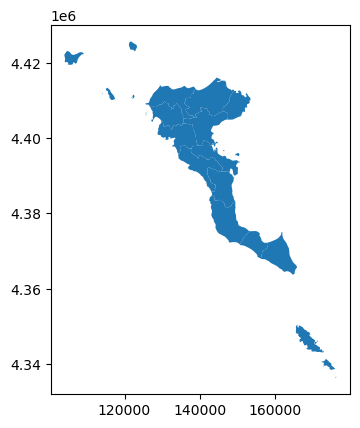

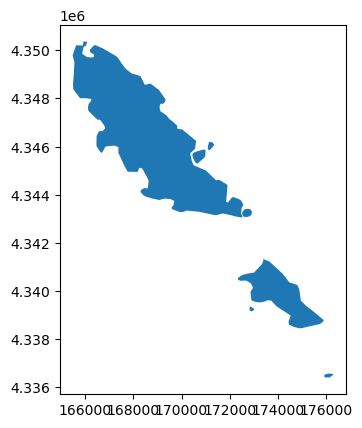

In [66]:
munis_c.plot()

munis_c[munis_c['EDRA'] == 'ΠΑΞΟΙ'].plot()